In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Install necessary libraries
!pip install torch torchvision timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.9 MB/s eta 0:00:00


In [2]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import f1_score
from timm import create_model
from torch.cuda.amp import autocast, GradScaler

In [3]:
# Define constants
data_dir = '/content/drive/MyDrive/Univ/Semester 5/JST/CNN/'  # Replace with the actual path
batch_size = 16
learning_rate = 0.001
epochs = 8

In [4]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
])

In [5]:
# Load dataset
train_dataset = datasets.ImageFolder(root=data_dir + '/train', transform=transform)
test_dataset = datasets.ImageFolder(root=data_dir + '/test', transform=transform)

In [6]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# Define MobileNetV3 model
model = create_model('mobilenetv3_large_100', pretrained=True, num_classes=3)
model.to(device)

model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (se): Identity()
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
 

In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# Lists to store training statistics
train_loss_history = []
accuracy_history = []

In [11]:
# Function to register hooks for feature extraction
def register_hooks(model):
    activations = []

    def hook_fn(module, input, output):
        activations.append(output)

    hooks = []
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            hook = layer.register_forward_hook(hook_fn)
            hooks.append(hook)

    return activations, hooks

In [12]:
# Extract activations and register hooks
activations, hooks = register_hooks(model)
scaler = GradScaler()

In [13]:
# Training loop with mixed precision
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Use autocast to enable mixed precision
        with autocast():
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Use scaler to perform backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate accuracy and append to history
    accuracy = correct_predictions / total_samples
    accuracy_history.append(accuracy)

    # Print training loss and accuracy for each epoch
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy}')

    # Append loss to history
    train_loss_history.append(running_loss/len(train_loader))

Epoch 1/8, Loss: 5.418405582021166, Accuracy: 0.4622475856014047
Epoch 2/8, Loss: 1.864710588555236, Accuracy: 0.5395083406496927
Epoch 3/8, Loss: 1.4315946523126188, Accuracy: 0.5781387181738367
Epoch 4/8, Loss: 1.125016084084144, Accuracy: 0.625548726953468
Epoch 5/8, Loss: 1.0578954446982671, Accuracy: 0.6580333625987709
Epoch 6/8, Loss: 0.9425339407020515, Accuracy: 0.6804214223002634
Epoch 7/8, Loss: 0.9491137086928307, Accuracy: 0.6808604038630377
Epoch 8/8, Loss: 0.8596549653089963, Accuracy: 0.6984196663740123


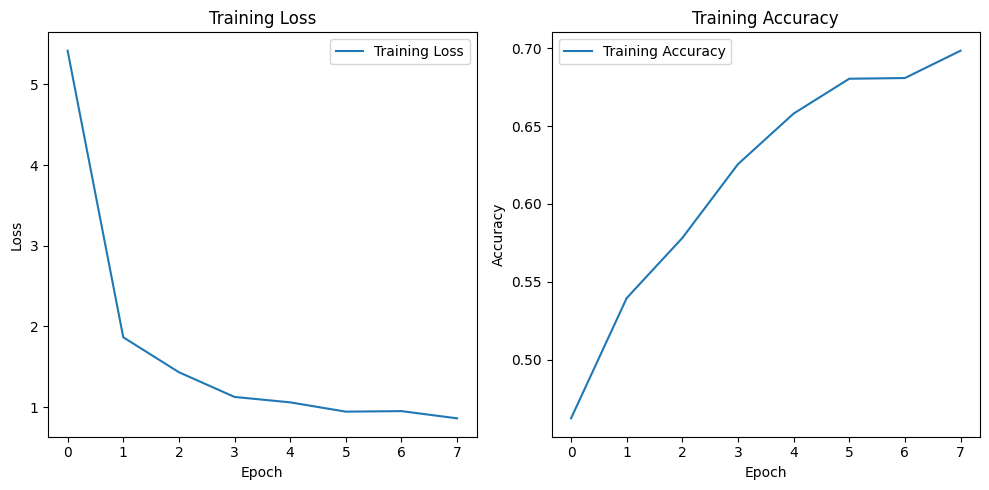

In [14]:
# Plot training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Visualize model architecture
#summary(model, (3, 48, 48), device=device)

In [17]:
# Visualize convolutional filters
# for i, activation in enumerate(activations):
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     plt.imshow(activation[0, 0].cpu().detach().numpy(), cmap='viridis')
#     plt.title(f'Convolutional Filters - Layer {i + 1}')
#     plt.colorbar()

#     plt.subplot(1, 2, 2)
#     plt.imshow(inputs[0, 0].cpu().detach().numpy(), cmap='gray')
#     plt.title('Input Image')
#     plt.colorbar()

#     plt.show()

In [18]:
# Remove hooks
for hook in hooks:
    hook.remove()

In [19]:
# Fine-tuning loop
fine_tune_epochs = 4  # You can adjust this value
fine_tune_train_loss_history = []
fine_tune_accuracy_history = []

for epoch in range(fine_tune_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Use autocast to enable mixed precision
        with autocast():
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Use scaler to perform backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate accuracy and append to history
    accuracy = correct_predictions / total_samples
    fine_tune_accuracy_history.append(accuracy)

    # Print training loss and accuracy for each epoch during fine-tuning
    print(f'Fine-tune Epoch {epoch + 1}/{fine_tune_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy}')

    # Append loss to history
    fine_tune_train_loss_history.append(running_loss/len(train_loader))

Fine-tune Epoch 1/4, Loss: 0.9130325133983905, Accuracy: 0.7124670763827919
Fine-tune Epoch 2/4, Loss: 0.7711349838263505, Accuracy: 0.7260755048287972
Fine-tune Epoch 3/4, Loss: 0.666076002421079, Accuracy: 0.7761194029850746
Fine-tune Epoch 4/4, Loss: 0.7088465700512165, Accuracy: 0.752414398595259


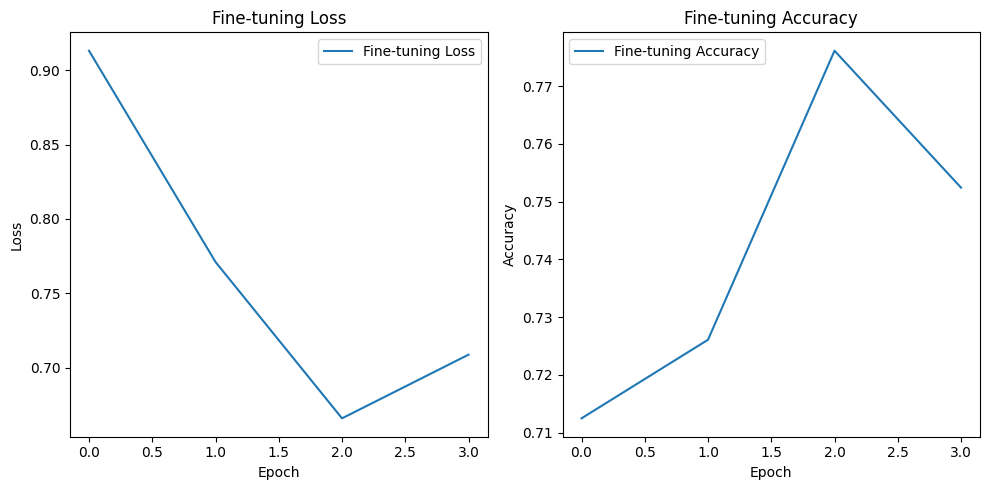

In [20]:
# Plot fine-tuning loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fine_tune_train_loss_history, label='Fine-tuning Loss')
plt.title('Fine-tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fine_tune_accuracy_history, label='Fine-tuning Accuracy')
plt.title('Fine-tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [26]:
import numpy as np
# Convert to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


In [27]:
# Calculate metrics
accuracy = (all_preds == all_labels).mean()
f1 = f1_score(all_labels, all_preds, average='weighted')

In [28]:
# Print metrics
print(f'Test Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

Test Accuracy: 0.5641476274165202
F1 Score: 0.5667055436303703
